In [59]:
import numpy as np
import pandas as pd

#------------------------- Feature Engineering -------------------------#

compas_scores_two_year= pd.read_csv("compas_scores_two_years.csv",  lineterminator='\n')

# Select features from dataset
df= compas_scores_two_year[[ 'juv_fel_count', 'juv_misd_count', 'juv_other_count' ,'age', 'c_charge_degree','race', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid',  'c_jail_in', 'c_jail_out',  'v_decile_score','two_year_recid\r']]
# Process the data
df = df.loc[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) & (df['is_recid'] != -1) & (df['c_charge_degree'] != 'O') & (df['score_text'] != 'N/A')]
#length of stay in jail 
df['length_of_stay'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['length_of_stay'] = df['length_of_stay'].astype('timedelta64[D]')
df['length_of_stay'] = df['length_of_stay'].astype(int)

#------------------------- Data Preprocessing -------------------------#
#split into caucasian and non-caucasian

df_CC = df.loc[df['race'] == 'Caucasian']
print('Caucasian', np.shape(df_CC))
df_AA = df.loc[df['race'] == 'African-American']
print('African-American', np.shape(df_AA))

df_NC = df.loc[df['race'] != 'Caucasian']

#equalizing odds 

def equilizing_odds(C):
    # #convert to probability
    # C = (1/len(F_true_score))*C
    # print(C)

    # False postive rates :Pr[ ˆY = 1/S = 1, Y = 0] − Pr[ ˆY = 0/S = 0, Y = 0]
    # False negative rates :Pr[ ˆY = 1/S = 1, Y = 1] − Pr[ ˆY = 0/S = 0, Y = 1]
    
    FNR = abs(C[0][0,1]/(C[0][0,1]+C[0][0,0]) - C[1][0,1]/(C[1][0,1]+C[1][0,0]))
    FPR = abs(C[0][1,0]/(C[0][1,0]+C[0][1,1]) - C[1][1,0]/(C[1][1,0]+C[1][1,1]))

    result = [FPR, FNR]

    return result

def KLDivergence(P, Q):
    return np.sum(np.where(P != 0, P * np.log(P / Q), 0))


#------------------------- create factors  -------------------------#

           

def factoration (df_x):
    def length_factoration (df_x):
        df= df_x
        #length of stay in jail 
        df['length_of_stay'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
        df['length_of_stay'] = df['length_of_stay'].astype('timedelta64[D]')
        df['length_of_stay'] = df.loc['length_of_stay'].astype(int)

        days = []
        weeks = []
        months = []
        years = []

        for length in df['length_of_stay']:
            if length<7:
                days.append(1)
                weeks.append(0)
                months.append(0)
                years.append(0)
            elif (length<30):
                days.append(0)
                weeks.append(1)
                months.append(0)
                years.append(0)
            elif length<365:
                days.append(0)
                weeks.append(0)
                months.append(1)
                years.append(0)
            else:
                days.append(0)
                weeks.append(0)
                months.append(0)
                years.append(1)

        return days, weeks, months, years

    def jail_factoration (df):
        jail_feature = []
        jail_feature_squared = []
        for jail in df['length_of_stay']:
            if(jail/365) > 1:
                jail_feature.append(1)
                jail_feature_squared.append((1)**2)
            else:
                jail_feature.append(jail/365)
                jail_feature_squared.append((jail/365)**2)
        return jail_feature, jail_feature_squared
  
    def age_factoration (df_x):
    
        df= df_x
        df_age = df['age'].astype(int)

        twenties_and_less = []
        thirties=[]
        fourties=[]
        fifties_and_more=[]

        for age in df_age:
            if age<30:
                twenties_and_less.append(1)
                thirties.append(0)
                fourties.append(0)
                fifties_and_more.append(0)
            elif age<40:
                twenties_and_less.append(0)
                thirties.append(1)
                fourties.append(0)
                fifties_and_more.append(0)
            elif age<50:
                twenties_and_less.append(0)
                thirties.append(0)
                fourties.append(1)
                fifties_and_more.append(0)
            else:
                twenties_and_less.append(0)
                thirties.append(0)
                fourties.append(0)
                fifties_and_more.append(1)

        return twenties_and_less, thirties, fourties, fifties_and_more
    
    def age_featrure (df_x):
        df= df_x
        df_age = df['age'].astype(int)
        mean_age = df_age.mean()
        age_feature_squared = []
        age_feature = []
        for age in df_age:
            if(age/mean_age) > 2:
                age_feature.append(2)
                age_feature_squared.append((2)**2)
            else:
                age_feature.append(age/mean_age)
                age_feature_squared.append((age/mean_age)**2)
        return age_feature, age_feature_squared

    def crime_factoration (df_x):
        df= df_x
        df_c_charge_degree = df[['c_charge_degree']] 
        crime_factor, u_charge_degree = pd.factorize(df_c_charge_degree['c_charge_degree'])
        return crime_factor

    def gender_factoration (df_x):
        df= df_x
        # Gender
        male = []
        female = []
        for gender in df['sex']:
            if gender == "Male":
                male.append(1)
                female.append(0)
            else:
                male.append(0)
                female.append(1)

        return male, female
    

    def priors_factoration (df_x):
        df= df_x
        
        # # Prior convictions
        juvinile_felonies  = df[['juv_fel_count']].astype(int)
        juvinile_misconduct  = df[['juv_misd_count']].astype(int)
        juvinile_other  = df[['juv_other_count']].astype(int)
        return juvinile_felonies, juvinile_misconduct, juvinile_other

    def prior_conviction_factoration (df_x):
        priors_count  = df['priors_count'].astype(int)
        no_prior_convictions = []
        one_prior =[]
        multiple_prior = []
        many_prior = []

        # Prior Convictions Feature
        for prior in priors_count:
            if prior==0:
                one_prior.append(0)
                multiple_prior.append(0)
                many_prior.append(0)
                no_prior_convictions.append(1)
            elif prior<2:
                one_prior.append(1)
                multiple_prior.append(0)
                many_prior.append(0)
                no_prior_convictions.append(0)
            elif prior<5:
                one_prior.append(0)
                multiple_prior.append(1)
                many_prior.append(0)
                no_prior_convictions.append(0)
            else:
                one_prior.append(0)
                multiple_prior.append(0)
                many_prior.append(1)
                no_prior_convictions.append(0)
        return no_prior_convictions, one_prior, multiple_prior, many_prior

    df= df_x
    #length factors 
    quick_stay, short_stay, medium_stay, long_stay = length_factoration(df)
    #age factors
    twenties_and_less, thirties, fourties, fifties_and_more = age_factoration(df)
    #charge factors
    crime_factor = crime_factoration(df)
    #gender factors
    male, non_male = gender_factoration(df)
    #priors factors
    juvinile_felonies, juvinile_misconduct, juvinile_other = priors_factoration(df)
    #prior convictions factors
    no_prior_convictions, one_prior, multiple_prior, many_prior = prior_conviction_factoration(df)
    #jail factors
    jail_feature, jail_feature_squared = jail_factoration(df)
    #age factors
    age_feature, age_feature_squared = age_featrure(df)

    X = np.column_stack((quick_stay, short_stay, medium_stay, long_stay, twenties_and_less, thirties, fourties, fifties_and_more, crime_factor, male, non_male, juvinile_felonies, juvinile_misconduct, juvinile_other, no_prior_convictions, one_prior, multiple_prior, many_prior, jail_feature, jail_feature_squared, age_feature, age_feature_squared))
    return X


##data_CC = factoration(df_CC)
#data_AA = factoration(df_NC)
#X = factoration(df)

# labels 
def labels(df_x):
    df= df_x
    compas_score = []
    for score in df['decile_score']:
        if score<5:
            compas_score.append(0)
        else:
            compas_score.append(1)
    
    two_year_recid = df[['two_year_recid\r']].astype(int)
    
    df_two_year= df[['two_year_recid\r']]
    two_year_recid, u_charge_degree = pd.factorize(df_two_year['two_year_recid\r'])
    #covert to numpy array
    

    return compas_score, two_year_recid

compas_score_CC, recid_CC = labels(df_CC)
compas_score_NC, recid_NC = labels(df_NC)








Caucasian (2103, 17)
African-American (3175, 17)


In [60]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(recid_CC, compas_score_CC), confusion_matrix(recid_NC, compas_score_NC)

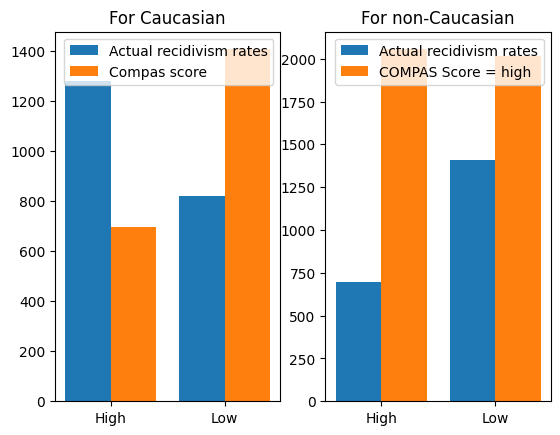

In [61]:
from matplotlib import pyplot as plt

#plot confusion matrix as histogram


Actual_recid_CC = [np.count_nonzero(recid_CC ), recid_CC.size-np.count_nonzero(recid_CC )]
Actual_recid_NC = [np.count_nonzero(recid_NC ), recid_NC.size-np.count_nonzero(recid_NC )]	

T_compas_score_CC = [np.count_nonzero(compas_score_CC ), len(compas_score_CC)-np.count_nonzero(compas_score_CC )]
T_compas_score_NC = [np.count_nonzero(compas_score_NC ), len(compas_score_NC)-np.count_nonzero(compas_score_NC )]
x_labels = ['High' ,'Low' ]
X_axis = np.arange(len(x_labels))

fig, ax= plt.subplots(nrows=1, ncols=2)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=X_axis, xticklabels=x_labels)



# Plot the data
ax[0].bar(X_axis - 0.2, Actual_recid_CC, 0.4, label='Actual recidivism rates')
ax[0].bar(X_axis + 0.2, T_compas_score_CC, 0.4, label='Compas score')
ax[0].set_title('For Caucasian')
ax[0].legend()

ax[1].bar(X_axis - 0.2, T_compas_score_CC, 0.4, label='Actual recidivism rates')
ax[1].bar(X_axis + 0.2, T_compas_score_NC, 0.4, label='COMPAS Score = high')
ax[1].set_title('For non-Caucasian')
ax[1].legend()

plt.show()




In [1]:
print (C[0][1])

print ('actual recidivism  for Caucasian', np.count_nonzero(recid_CC ))

#equlising odds 
from sklearn.metrics import confusion_matrix

C = confusion_matrix(recid_CC, compas_score_CC), confusion_matrix(recid_NC, compas_score_NC)

#equalising odds
print('-----------------Equilizing_odds -----------------')
print('False postive rates |Pr[ Y^ = 1/S = 1, Y = 0] − Pr[ Y^ = 0/S = 0, Y = 0]|  = ',   equilizing_odds(C)[0])
print('False negative rates  |Pr[ Y^ = 1/S = 1, Y = 1] − Pr[ Y^ = 0/S = 0, Y = 1]| = ', equilizing_odds(C)[1])

#kld 
print('-----------------KLD -----------------')
# probility of recidivism for Caucasian
p = np.count_nonzero(recid_CC )/len(recid_CC)
# probility of recidivism for non-Caucasian
q = np.count_nonzero(compas_score_CC )/len(compas_score_CC)
# probility of COMPAS score for Caucasian 
print('KLD between Pr[recid_CC] and P[compas_CC]= ', KLDivergence(p, q))
# probility of COMPAS score for non-Caucasian
p = np.count_nonzero(recid_NC )/len(recid_NC)
q = np.count_nonzero(compas_score_NC )/len(compas_score_NC)
print('KLD between Pr[recid_NC] and P[compas_score_NC]= ', KLDivergence(p, q))









NameError: name 'C' is not defined

-0.08925742052568389
